# Práctica 2: Sensado y análisis de video

## Alumno: Mario Alberto Lizárraga Reyes

Para esta práctica, se realizó un notebook para el procesado de videos del protocolo FMA-UE, de los cuales se extrajeron landmarks para el entrenamiento de 5 modelos distintos para la detección del rango de movimiento en base al ejercicio realizado.

El dataset contiene 5 movimientos diferentes
Abducción 
Extensión de codo
Extensión de dedos
Flexión
Rotación externa

De los cuales, se clasificaron 3 rangos distintos, completo, parcial y nulo

Para la extracción, etiquetado y entrenamiento, se separaron los videos por carpetas para cada persona y se nombraron con el formato "movimiento_rango.mp4"

Ejemplos:

abduccion_completo.mp4

extensioncodo_nulo.mp4

extensiondedos_parcial.mp4

rotacionexterna_parcial.mp4

flexion_completo.mp4

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import os
import pandas as pd
import joblib
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix


#Inicializamos mediapipe
mp_hands = mp.solutions.hands
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()
hands = mp_hands.Hands()
mp_drawing = mp.solutions.drawing_utils

#Path para la carpeta de videos y el output de la extracción de landmarks
DATASET_PATH = "Videos"
OUTPUT_CSV = "landmarks_stats.csv"

In [ ]:
#Función para extraer landmarks, solo extrae hombro, codo y muñeca del lado derecho y los dedos en el movimiento extensiondedos
def extract_landmarks_from_video(video_path):

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    landmarks_data = []

    # Determinar el tipo de movimiento desde el nombre del archivo
    filename = os.path.basename(video_path)
    movimiento = filename.split("_")[0]  # Extraer nombre del movimiento

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1

        # Solo procesar cada 4 frames (tuve que re procesar varias veces y se tardaba 30 minutos por procesada sin este skip)
        if frame_count % 4 != 0:
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        pose_results = pose.process(frame_rgb)
        hands_results = hands.process(frame_rgb)

        if pose_results.pose_landmarks:
            pose_landmarks = pose_results.pose_landmarks.landmark

            # Extraer solo los landmarks del lado derecho
            shoulder_r = [pose_landmarks[12].x, pose_landmarks[12].y, pose_landmarks[12].z]
            elbow_r = [pose_landmarks[14].x, pose_landmarks[14].y, pose_landmarks[14].z]
            wrist_r = [pose_landmarks[16].x, pose_landmarks[16].y, pose_landmarks[16].z]

            # Si el movimiento es "extensiondedos", extraer landmarks de los dedos
            finger_landmarks = [None] * 15  # 5 dedos × 3 coordenadas cada uno (x, y, z)

            if movimiento == "extensiondedos" and hands_results.multi_hand_landmarks:
                for hand_landmarks in hands_results.multi_hand_landmarks:
                    temp_finger_landmarks = []
                    for i in [4, 8, 12, 16, 20]:  # Puntas de los dedos
                        landmark = hand_landmarks.landmark[i]
                        temp_finger_landmarks.extend([landmark.x, landmark.y, landmark.z])

                    # Si realmente se encontraron landmarks de la mano, usarlos
                    if len(temp_finger_landmarks) == 15:
                        finger_landmarks = temp_finger_landmarks

            # Appedn en la lista
            landmarks_data.append([video_path] + shoulder_r + elbow_r + wrist_r + finger_landmarks)

    cap.release()

    # Definir todas las columnas
    columns = [
        "video_path",
        "shoulder_r_x", "shoulder_r_y", "shoulder_r_z",
        "elbow_r_x", "elbow_r_y", "elbow_r_z",
        "wrist_r_x", "wrist_r_y", "wrist_r_z",
        "thumb_r_x", "thumb_r_y", "thumb_r_z",
        "index_r_x", "index_r_y", "index_r_z",
        "middle_r_x", "middle_r_y", "middle_r_z",
        "ring_r_x", "ring_r_y", "ring_r_z",
        "pinky_r_x", "pinky_r_y", "pinky_r_z"
    ]

    return pd.DataFrame(landmarks_data, columns=columns)



In [ ]:
#Función para procesado carpeta por carpeta y video por video
dataset = []

for person_folder in os.listdir(DATASET_PATH):
    person_path = os.path.join(DATASET_PATH, person_folder)

    if os.path.isdir(person_path):
        for video in os.listdir(person_path):
            video_path = os.path.join(person_path, video)
            df_video = extract_landmarks_from_video(video_path)
            print("Landmarks extraidos en ", video)

            if not df_video.empty:
                df_video["movement_label"] = os.path.basename(video_path).split("_")[0]
                df_video["range_label"] = os.path.basename(video_path).split("_")[-1].replace(".mp4", "")
                dataset.append(df_video)

# Concatenar todos los DataFrames y guardar
df = pd.concat(dataset, ignore_index=True)
df.to_csv(OUTPUT_CSV, index=False)
print(f"Dataset guardado en {OUTPUT_CSV}")


### Función solo para visualizar la extracción de landmarks 

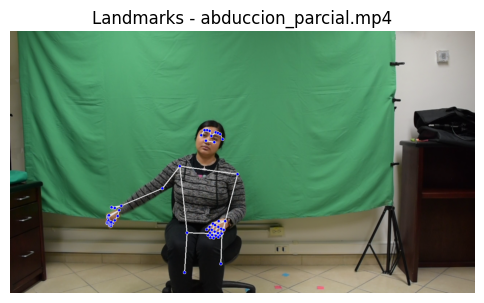

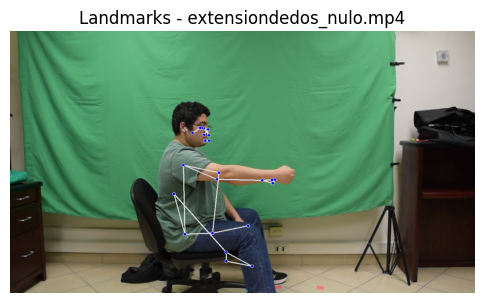

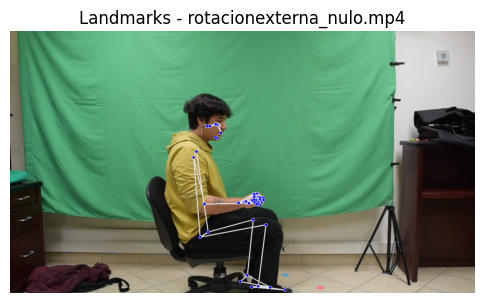

In [ ]:
import random

def show_random_landmarks():

    selected_videos = []

    # Obtener una lista de personas en el dataset
    persons = [p for p in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, p))]
    

    # Seleccionar 3 personas random
    selected_persons = random.sample(persons, 3)

    for person in selected_persons:
        person_path = os.path.join(DATASET_PATH, person)

        videos = [f for f in os.listdir(person_path) if f.endswith(".mp4")]

        # Seleccionar un video random de esta persona
        video_path = os.path.join(person_path, random.choice(videos))
        selected_videos.append(video_path)

    # Procesar los videos de la lista
    for video_path in selected_videos:
        cap = cv2.VideoCapture(video_path)
        frames = []

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)

        cap.release()

        if not frames:
            print(f"No se pudieron leer frames en {video_path}")
            continue

        # Seleccionar un frame random
        selected_frame = random.choice(frames)

        # Convertir a RGB y procesar con Mediapipe
        frame_rgb = cv2.cvtColor(selected_frame, cv2.COLOR_BGR2RGB)
        pose_results = pose.process(frame_rgb)
        hands_results = hands.process(frame_rgb)

        # Dibujar landmarks si fueron detectados
        if pose_results.pose_landmarks:
            mp_drawing.draw_landmarks(frame_rgb, pose_results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

        if hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(frame_rgb, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        # Mostrar el frame con los landmarks
        plt.figure(figsize=(6, 6))
        plt.imshow(frame_rgb)
        plt.title(f"Landmarks - {os.path.basename(video_path)}")
        plt.axis("off")
        plt.show()

show_random_landmarks()


In [59]:
df = pd.read_csv(OUTPUT_CSV)

# Convertir etiquetas en números
encoder_range = LabelEncoder()
df["range_label"] = encoder_range.fit_transform(df["range_label"])

# Separar datasets por movimiento
movimientos = df["movement_label"].unique()
datasets = {mov: df[df["movement_label"] == mov].copy() for mov in movimientos}


In [ ]:
#Entrenamiento de modelos
modelos = {}

for movimiento, data in datasets.items():
    print(f"Entrenando modelo para {movimiento}...")

    # Separar features y etiquetas
    X = data.drop(columns=["video_path", "movement_label", "range_label"])
    y = data["range_label"]

    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_idx, test_idx in sss.split(X_scaled, y):
        X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Entrenar modelo Random Forest
    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    # Evaluar modelo
    y_pred = modelo.predict(X_test)
    print(f"\nReporte de clasificación para {movimiento}:\n")
    print(classification_report(y_test, y_pred, target_names=encoder_range.classes_))

    # Guardar modelo
    modelos[movimiento] = modelo
    joblib.dump(modelo, f"modelo_{movimiento}.pkl")
    joblib.dump(scaler, f"scaler_{movimiento}.pkl")

print("Entrenamiento completado y modelos guardados.")


Evaluando modelo para abduccion...


C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Cross-validation accuracy para abduccion: 0.9077 (+/- 0.0072)


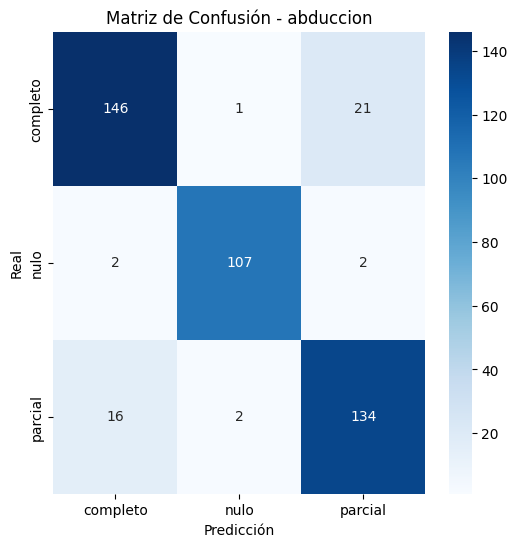

Evaluando modelo para extensioncodo...


C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Cross-validation accuracy para extensioncodo: 0.9556 (+/- 0.0054)


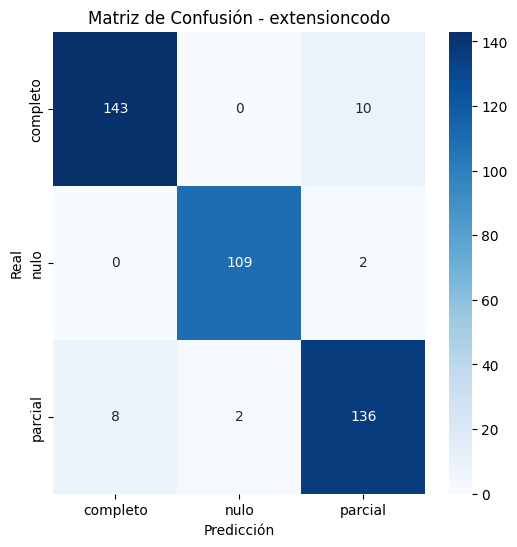

Evaluando modelo para extensiondedos...
Cross-validation accuracy para extensiondedos: 0.9914 (+/- 0.0055)


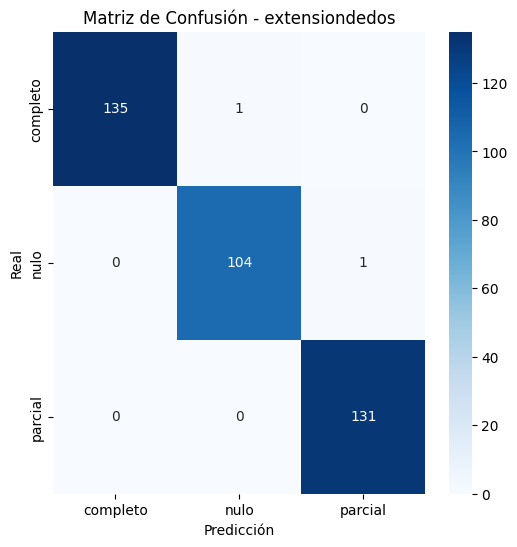

Evaluando modelo para flexion...


C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Cross-validation accuracy para flexion: 0.9110 (+/- 0.0158)


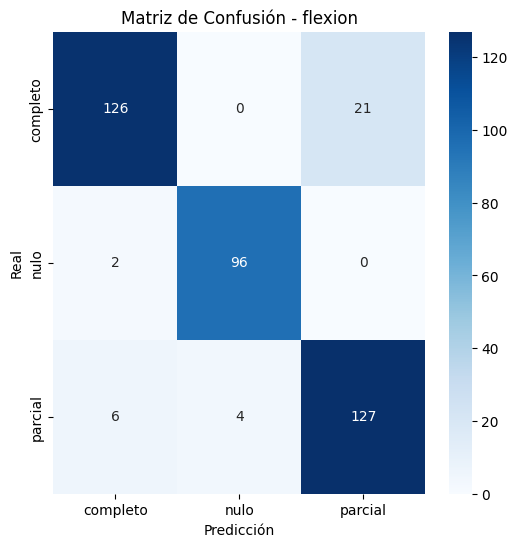

Evaluando modelo para rotacionexterna...


C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Cross-validation accuracy para rotacionexterna: 0.9895 (+/- 0.0037)


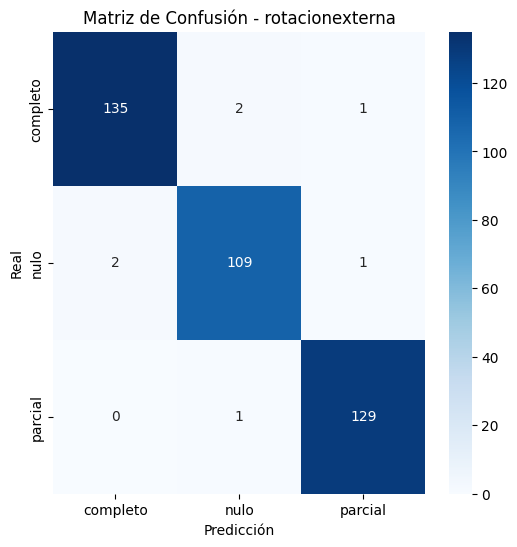

In [ ]:
num_folds = 5

for movimiento, data in datasets.items():
    print(f"Evaluando modelo para {movimiento}...")

    # Separar características y etiquetas
    X = data.drop(columns=["video_path", "movement_label", "range_label"])
    y = data["range_label"]

    # Normalizar datos
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Definir modelo
    modelo = RandomForestClassifier(n_estimators=100, random_state=42)

    # Validación cruzada
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
    scores = cross_val_score(modelo, X_scaled, y, cv=skf, scoring="accuracy")

    print(f"Cross-validation accuracy para {movimiento}: {scores.mean():.4f} (+/- {scores.std():.4f})")

    # Entrenar modelo para obtener la matriz de confusión
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Crear una figura individual para cada matriz de confusión
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=encoder_range.classes_,
                yticklabels=encoder_range.classes_)
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {movimiento}")
    plt.show()


#### Observando las matrices, se puede ver cómo los movimientos de flexión y abducción de hombro obtuvieron la mayor cantidad de errores, en especifico mostrando confusión entre completo y parcial, por lo que una posilble mejora podria ser la optimización de la distinción de estos rangos ajustando los umbrales de movimiento o aumentando la cantidad de datos en los rangos con más confusión.

In [ ]:
def predict_range(video_path):
    """
    Extrae landmarks en tiempo real y predice el rango de movimiento basado en el video dado.
    La salida incluye la comparación entre el rango real y el rango predicho.
    """
    df_video = extract_landmarks_from_video(video_path)

    if df_video.empty:
        print(f"No se pudo extraer información de {video_path}")
        return

    # Extraer el nombre del archivo sin el path y sin ".mp4"
    video_name = os.path.basename(video_path).replace(".mp4", "")

    parts = video_name.split("_")
    movimiento = parts[0] 
    rango_real = parts[-1] if len(parts) > 1 else "Desconocido"  # Si no hay rango en el nombre, asigna "Desconocido"

    if movimiento not in modelos:
        print(f"No hay modelo entrenado para el movimiento {movimiento}")
        return

    # Cargar modelo
    modelo = joblib.load(f"modelo_{movimiento}.pkl")
    scaler = joblib.load(f"scaler_{movimiento}.pkl")

    # Verificar las columnas por un bug que tenía 
    columns_to_remove = ["video_path", "movement_label", "range_label"]
    existing_columns = [col for col in columns_to_remove if col in df_video.columns]

    # Normalizar los datos
    X_new_scaled = scaler.transform(df_video.drop(columns=existing_columns))

    # Hacer la predicción
    pred = modelo.predict(X_new_scaled)
    rango_predicho = encoder_range.inverse_transform(pred)[0]

    # Print bonito para el output
    print(f"Video: {video_name}")
    print(f"Movimiento: {movimiento}")
    print(f"Rango Real: {rango_real} | Rango Predicho: {rango_predicho}")




## Funciones para evaluar


La primera función para evaluación es predict_random_video_per_person(), la cual selecciona un video aleatorio por persona del dataset y la evalua en su respectivo modelo, en el print se puede observar la predicción del modelo vs el resultado real que está en el nombre del archivo

Este bloque se puede volver a correr para ver la evaluación de distintos videos aleatorios

In [ ]:
import random

def predict_random_video_per_person():

    # Recorrer cada carpeta
    for person_folder in os.listdir(DATASET_PATH):
        person_path = os.path.join(DATASET_PATH, person_folder)

        if os.path.isdir(person_path):
            videos = [f for f in os.listdir(person_path) if f.endswith(".mp4")]

            # Seleccionar un video rnadom
            video_name = random.choice(videos)
            video_path = os.path.join(person_path, video_name)
            print(f"Evaluando {video_path}...")

            # Extraer el rango real desde el nombre del archivo
            rango_real = video_name.split("_")[-1].replace(".mp4", "")

            # Extraer landmarks
            df_video = extract_landmarks_from_video(video_path)

            if df_video.empty:
                print(f"No se pudieron extraer landmarks de {video_path}")
                continue

            # Determinar el movimiento desde el nombre del archivo
            movimiento = video_name.split("_")[0]

            if movimiento not in modelos:
                print(f"No hay modelo entrenado para el movimiento {movimiento}")
                continue

            # Cargar modelo
            modelo = joblib.load(f"modelo_{movimiento}.pkl")
            scaler = joblib.load(f"scaler_{movimiento}.pkl")

            # Normalizar los datos
            X_new_scaled = scaler.transform(df_video.drop(columns=["video_path"]))

            # Hacer la predicción
            pred = modelo.predict(X_new_scaled)
            rango_predicho = encoder_range.inverse_transform(pred)[0]

            # Imprimir comparación entre el rango real y el rango predicho
            print(f"Video: {video_name}")
            print(f"Movimiento: {movimiento}")
            print(f"Rango Real: {rango_real} | Rango Predicho: {rango_predicho}")
            print("-" * 50)

predict_random_video_per_person()


Evaluando Videos\Persona1\flexion_parcial.mp4...
Video: flexion_parcial.mp4
Movimiento: flexion
Rango Real: parcial | Rango Predicho: completo
--------------------------------------------------
Evaluando Videos\Persona10\extensiondedos_completo.mp4...
Video: extensiondedos_completo.mp4
Movimiento: extensiondedos
Rango Real: completo | Rango Predicho: completo
--------------------------------------------------
Evaluando Videos\Persona2\extensiondedos_parcial.mp4...
Video: extensiondedos_parcial.mp4
Movimiento: extensiondedos
Rango Real: parcial | Rango Predicho: completo
--------------------------------------------------
Evaluando Videos\Persona3\flexion_nulo.mp4...
Video: flexion_nulo.mp4
Movimiento: flexion
Rango Real: nulo | Rango Predicho: nulo
--------------------------------------------------
Evaluando Videos\Persona4\abduccion_nulo.mp4...
Video: abduccion_nulo.mp4
Movimiento: abduccion
Rango Real: nulo | Rango Predicho: nulo
--------------------------------------------------
Eval

En el print se puede observar los videos seleccionados de manera aleatoria, el movimiento y el vs del rango predicho contra el real, teniendo correctos 5 de 10

## Ejemplo de uso para evaluación externa

Pegar path del video a usar con el formato "movimiento_rango.mp4"
El movimiento se extrae para usar el modelo adecuado y el rango solo para hacer la comparación de lo real vs lo predicho

En el caso del ejemplo, el video usado está incluido en la carpeta de la práctica


In [98]:
video_a_evaluar = r'C:\Users\lizar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\Scripts\Escuela\CDSI\P2\extensioncodo_parcial.mp4'
predict_range(video_a_evaluar)


Video: extensioncodo_parcial
Movimiento: extensioncodo
Rango Real: parcial | Rango Predicho: completo
--------------------------------------------------


#### Como conclusión, fue interesante el procesamiento del video y el uso de landmarks, sin embargo durante la evaluación fue muy obvio que las condiciones de grabado del video como iluminación y calidad afectan demasiado a los resultados, ya que hubo un par de videos con los que intenté que no era capaz de obtener siquiera extracción de landmarks. Usando videos que eran parte del data set los resultados no fueron tan malos, pero puedo concluir sin duda alguna que al modelo le falta robustez para poder adaptarse a este tipo de situaciones.